In [39]:
import datetime
import os
from functools import partial
import joblib
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.mixture import BayesianGaussianMixture
from functools import partial
from sklearn.preprocessing import OneHotEncoder
import tensorflow_probability as tfp
from sklearn.preprocessing import MinMaxScaler

import shutil
from functools import reduce
from tqdm.autonotebook import tqdm

!pip install wget
import wget

import warnings
warnings.filterwarnings("ignore")

In [40]:
class GANEvaluation:
  def __init__(self):
    self.colors = ['blue', 'orange', 'red', 'green', 'purple', 'pink', 'brown', 'cyan', 'magenta', 'yellow']
    pass

  def plot_kde(self, data=()):
    plt.figure(figsize=(15, 10))
    if len(data) == 0:
      raise ValueError('No data provided')

    for i in range(len(data)-1):
      assert len(data[i].columns) == len(data[i+1].columns)
      for j in range(len(data[i].columns)):
        assert data[i].columns[j] == data[i+1].columns[j]

    num_columns = len(data[0].columns)

    for i in range(num_columns):
      plt.subplot((num_columns // 3) + 1, 3, i+1)
      for j, df in enumerate(data):
        sns.kdeplot(df[df.columns[i]], shade=True, color=self.colors[j],
                    label=f'{"Real Data" if j == 0 else "Generated Data"}')
        plt.legend(prop={'size': 5})

  def plot_losses(self, losses):
    plt.figure(figsize=(10,5))
    plt.plot(losses["g_loss"], label='Generator Loss')
    plt.plot(losses["d_loss"], label='Discriminator Loss')
    plt.title('GAN Losses Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# Layer Utils


In [41]:
def init_bounded(shape, **kwargs):
    if 'dim' not in kwargs:
        raise AttributeError('dim not passed as input')
    if 'dtype' not in kwargs:
        raise AttributeError('dtype not passed as input')

    dim = kwargs['dim']
    d_type = kwargs['dtype']
    bound = 1 / math.sqrt(dim)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=d_type)

# Layers


In [42]:
class GenActivation(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, transformer_info, tau):
        super(GenActivation, self).__init__()
        self._output_dim = output_dim
        self._transformer_info = transformer_info
        self._tau = tau
        self._fc = tf.keras.layers.Dense(
            output_dim, input_dim=(input_dim,),
            kernel_initializer=partial(init_bounded, dim=input_dim),
            bias_initializer=partial(init_bounded, dim=input_dim))

    def call(self, inputs, training=False, **kwargs):
        outputs = self._fc(inputs, **kwargs)
        data_t = tf.zeros(tf.shape(outputs))
        for idx in self._transformer_info:
            if idx[2] == 0:
                act = tf.math.tanh(outputs[:, idx[0]:idx[1]])
            else:
                act = self._gumbel_softmax(outputs[:, idx[0]:idx[1]], self._tau, training=training)
            data_t = tf.concat([data_t[:, :idx[0]], act, data_t[:, idx[1]:]], 1)
        return outputs, data_t

    @tf.function(experimental_relax_shapes=True)
    def _gumbel_softmax(self, logits, tau=1.0, hard=False, training=True, dim=-1):
        if not training:
            # When not training, use hard Gumbel-Softmax to remove randomness
            hard = True

        if hard:
            # Use a straight-through Gumbel-Softmax (hard)
            y = tf.nn.softmax(logits / tau, axis=dim)
            y_hard = tf.cast(tf.equal(y, tf.reduce_max(y, axis=dim, keepdims=True)), y.dtype)
            y = tf.stop_gradient(y_hard - y) + y
            return y
        else:
            # Standard Gumbel-Softmax operation (soft, with randomness)
            gumbel_dist = tfp.distributions.Gumbel(loc=0, scale=1)
            gumbels = gumbel_dist.sample(tf.shape(logits))
            gumbels = (logits + gumbels) / tau
            y = tf.nn.softmax(gumbels, dim)
            return y

class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(ResidualLayer, self).__init__()
        self._output_dim = output_dim
        self._fc = tf.keras.layers.Dense(
            self._output_dim,
            input_dim=(input_dim,),
            kernel_initializer=partial(init_bounded, dim=input_dim),
            bias_initializer=partial(init_bounded, dim=input_dim))
        self._bn = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self._relu = tf.keras.layers.ReLU()

    def call(self, inputs, **kwargs):
        outputs = self._fc(inputs, **kwargs)
        outputs = self._bn(outputs, **kwargs)
        outputs = self._relu(outputs, **kwargs)
        return tf.concat([outputs, inputs], 1)

# Models


In [43]:
class BGM(BayesianGaussianMixture):
    def __eq__(self, other):
        try:
            np.testing.assert_equal(self.__dict__, other.__dict__)
            return True
        except AssertionError:
            return False

class Critic(tf.keras.Model):
    def __init__(self, input_dim, dis_dims, pac):
        super(Critic, self).__init__()
        self._pac = pac
        self._input_dim = input_dim

        self._model = [self._reshape_func]
        dim = input_dim * self._pac
        for layer_dim in list(dis_dims):
            self._model += [
                tf.keras.layers.Dense(
                    layer_dim, input_dim=(dim,),
                    kernel_initializer=partial(init_bounded, dim=dim),
                    bias_initializer=partial(init_bounded, dim=dim)),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Dropout(0.5)]
            dim = layer_dim

        layer_dim = 1
        self._model += [tf.keras.layers.Dense(
            layer_dim, input_dim=(dim,),
            kernel_initializer=partial(init_bounded, dim=dim),
            bias_initializer=partial(init_bounded, dim=dim))]

    def _reshape_func(self, inputs, **kwargs):
        dims = inputs.get_shape().as_list()
        return tf.reshape(inputs, [-1, dims[1] * self._pac])

    def call(self, inputs, **kwargs):
        outputs = inputs
        for layer in self._model:
            outputs = layer(outputs, **kwargs)
        return outputs

class Generator(tf.keras.Model):
    def __init__(self, input_dim, gen_dims, data_dim, transformer_info, tau):
        super(Generator, self).__init__()

        self._input_dim = input_dim
        self._model = list()
        dim = input_dim
        for layer_dim in list(gen_dims):
            self._model += [ResidualLayer(dim, layer_dim)]
            dim += layer_dim

        self._model += [GenActivation(dim, data_dim, transformer_info, tau)]

    def call(self, inputs, **kwargs):
        outputs = inputs
        for layer in self._model:
            outputs = layer(outputs, **kwargs)
        return outputs

class OHE(OneHotEncoder):
     def __eq__(self, other):
        try:
            np.testing.assert_equal(self.__dict__, other.__dict__)
            return True
        except AssertionError:
            return False

# Data Modules

In [44]:
class DataTransformer:

    @classmethod
    def from_dict(cls, in_dict):
        new_instance = DataTransformer()
        new_instance.__dict__ = in_dict
        return new_instance

    def __init__(self, n_clusters=10, epsilon=0.005):
        self._n_clusters = n_clusters
        self._epsilon = epsilon
        self._is_dataframe = None
        self._meta = None
        self._dtypes = None

        self.output_info = None
        self.output_dimensions = None
        self.output_tensor = None
        self.cond_tensor = None

    def generate_tensors(self):
        if self.output_info is None:
            raise AttributeError("Output info still not available")

        output_info = []
        cond_info = []
        i = 0
        st_idx = 0
        st_c = 0
        for item in self.output_info:
            ed_idx = st_idx + item[0]
            if not item[2]:
                ed_c = st_c + item[0]
                cond_info.append(tf.constant(
                    [st_idx, ed_idx, st_c, ed_c, i], dtype=tf.int32))
                st_c = ed_c
                i += 1

            output_info.append(tf.constant(
                [st_idx, ed_idx, int(item[1] == 'softmax')], dtype=tf.int32))
            st_idx = ed_idx

        self.output_tensor = output_info
        self.cond_tensor = cond_info

    @ignore_warnings(category=ConvergenceWarning)
    def _fit_continuous(self, column, data):
        vgm = BGM(
            n_components=self._n_clusters,
            weight_concentration_prior_type='dirichlet_process',
            weight_concentration_prior=0.001,
            n_init=1
        )
        vgm.fit(data)
        components = vgm.weights_ > self._epsilon
        num_components = components.sum()

        return {
            'name': column,
            'model': vgm,
            'components': components,
            'output_info': [(1, 'tanh', 1), (num_components, 'softmax', 1)],
            'output_dimensions': 1 + num_components,
        }

    def _fit_discrete(self, column, data):
        ohe = OHE(sparse=False)
        ohe.fit(data)
        categories = len(ohe.categories_[0])

        return {
            'name': column,
            'encoder': ohe,
            'output_info': [(categories, 'softmax', 0)],
            'output_dimensions': categories
        }

    def fit(self, data, discrete_columns=tuple()):
        self.output_info = []
        self.output_dimensions = 0

        if not isinstance(data, pd.DataFrame):
            self._is_dataframe = False
            data = pd.DataFrame(data)
        else:
            self._is_dataframe = True

        self._dtypes = data.infer_objects().dtypes
        self._meta = []
        for column in data.columns:
            column_data = data[[column]].values
            if column in discrete_columns:
                meta = self._fit_discrete(column, column_data)
            else:
                meta = self._fit_continuous(column, column_data)

            self.output_info += meta['output_info']
            self.output_dimensions += meta['output_dimensions']
            self._meta.append(meta)

    def _transform_continuous(self, column_meta, data):
        components = column_meta['components']
        model = column_meta['model']

        means = model.means_.reshape((1, self._n_clusters))
        stds = np.sqrt(model.covariances_).reshape((1, self._n_clusters))
        features = (data - means) / (4 * stds)

        probs = model.predict_proba(data)

        n_opts = components.sum()
        features = features[:, components]
        probs = probs[:, components]

        opt_sel = np.zeros(len(data), dtype='int')
        for i in range(len(data)):
            norm_probs = probs[i] + 1e-6
            norm_probs = norm_probs / norm_probs.sum()
            # opt_sel[i] = np.random.choice(np.arange(n_opts), p=norm_probs)
            opt_sel[i] = np.argmax(norm_probs)

        idx = np.arange((len(features)))
        features = features[idx, opt_sel].reshape([-1, 1])
        features = np.clip(features, -.99, .99)

        probs_onehot = np.zeros_like(probs)
        probs_onehot[np.arange(len(probs)), opt_sel] = 1
        return [features, probs_onehot]

    def _transform_discrete(self, column_meta, data):
        encoder = column_meta['encoder']
        return encoder.transform(data)

    def transform(self, data):
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)

        values = []
        for meta in self._meta:
            column_data = data[[meta['name']]].values
            if 'model' in meta:
                values += self._transform_continuous(meta, column_data)
            else:
                values.append(self._transform_discrete(meta, column_data))

        return np.concatenate(values, axis=1).astype(float)

    def _inverse_transform_continuous(self, meta, data, sigma=None):
        model = meta['model']
        components = meta['components']

        mean = data[:, 0]
        variance = data[:, 1:]

        # if sigma is not None:
        #     mean = np.random.normal(mean, sigma)

        mean = np.clip(mean, -1, 1)
        v_t = np.ones((len(data), self._n_clusters)) * -100
        v_t[:, components] = variance
        variance = v_t
        means = model.means_.reshape([-1])
        stds = np.sqrt(model.covariances_).reshape([-1])
        p_argmax = np.argmax(variance, axis=1)
        std_t = stds[p_argmax]
        mean_t = means[p_argmax]
        column = mean * 4 * std_t + mean_t

        return column

    def _inverse_transform_discrete(self, meta, data):
        encoder = meta['encoder']
        return encoder.inverse_transform(data)

    def inverse_transform(self, data, sigmas=None):
        start = 0
        output = []
        column_names = []
        for meta in self._meta:
            dimensions = meta['output_dimensions']
            columns_data = data[:, start:start + dimensions]

            if 'model' in meta:
                sigma = sigmas[start] if sigmas else None
                inverted = self._inverse_transform_continuous(
                    meta, columns_data, sigma)
            else:
                inverted = self._inverse_transform_discrete(meta, columns_data)

            output.append(inverted)
            column_names.append(meta['name'])
            start += dimensions

        output = np.column_stack(output)
        output = pd.DataFrame(output, columns=column_names)\
            .astype(self._dtypes)
        if not self._is_dataframe:
            output = output.values

        return output

class DataSampler:
    def __init__(self, data, output_info):
        super(DataSampler, self).__init__()
        self._data = data
        self._model = []
        self._n = len(data)

        st_idx = 0
        skip = False
        for item in output_info:
            if item[1] == 'tanh':
                st_idx += item[0]
                skip = True
            elif item[1] == 'softmax':
                if skip:
                    skip = False
                    st_idx += item[0]
                    continue

                ed_idx = st_idx + item[0]
                tmp = []
                for j in range(item[0]):
                    tmp.append(np.nonzero(data[:, st_idx + j])[0])

                self._model.append(tmp)
                st_idx = ed_idx
            else:
                assert 0

        assert st_idx == data.shape[1]

    def sample(self, n_samples, col_idx, opt_idx):
        if col_idx is None:
            idx = np.random.choice(np.arange(self._n), n_samples)
            return self._data[idx]

        idx = []
        for col, opt in zip(col_idx, opt_idx):
            idx.append(np.random.choice(self._model[col][opt]))

        return self._data[idx]

class ConditionalGenerator:
    @classmethod
    def from_dict(cls, in_dict):
        new_instance = ConditionalGenerator()
        new_instance.__dict__ = in_dict
        return new_instance

    def __init__(self, data=None, output_info=None, log_frequency=None):
        if data is None or output_info is None or log_frequency is None:
            return

        self._model = []

        start = 0
        skip = False
        max_interval = 0
        counter = 0
        for item in output_info:
            if item[1] == 'tanh':
                start += item[0]
                skip = True
                continue

            if item[1] == 'softmax':
                if skip:
                    skip = False
                    start += item[0]
                    continue

                end = start + item[0]
                max_interval = max(max_interval, end - start)
                counter += 1
                self._model.append(np.argmax(data[:, start:end], axis=-1))
                start = end

            else:
                assert 0

        assert start == data.shape[1]

        self._interval = []
        self._n_col = 0
        self.n_opt = 0
        skip = False
        start = 0
        self._p = np.zeros((counter, max_interval))
        for item in output_info:
            if item[1] == 'tanh':
                skip = True
                start += item[0]
                continue
            if item[1] == 'softmax':
                if skip:
                    start += item[0]
                    skip = False
                    continue
                end = start + item[0]
                tmp = np.sum(data[:, start:end], axis=0)
                if log_frequency:
                    tmp = np.log(tmp + 1)
                tmp = tmp / np.sum(tmp)
                self._p[self._n_col, :item[0]] = tmp
                self._interval.append((self.n_opt, item[0]))
                self.n_opt += item[0]
                self._n_col += 1
                start = end
            else:
                assert 0

        self._interval = np.asarray(self._interval)

    def _random_choice_prob_index(self, idx):
        prob = self._p[idx]
        rand = np.expand_dims(np.random.rand(prob.shape[0]), axis=1)
        return (prob.cumsum(axis=1) > rand).argmax(axis=1)

    def sample(self, batch_size):
        if self._n_col == 0:
            return None

        col_idx = np.random.choice(np.arange(self._n_col), batch_size)

        cond = np.zeros((batch_size, self.n_opt), dtype='float32')
        mask = np.zeros((batch_size, self._n_col), dtype='float32')

        mask[np.arange(batch_size), col_idx] = 1
        opt_idx = self._random_choice_prob_index(col_idx)
        opt = self._interval[col_idx, 0] + opt_idx
        cond[np.arange(batch_size), opt] = 1
        return cond, mask, col_idx, opt_idx

    def sample_zero(self, batch_size):
        if self._n_col == 0:
            return None

        vec = np.zeros((batch_size, self.n_opt), dtype='float32')
        idx = np.random.choice(np.arange(self._n_col), batch_size)
        for i in range(batch_size):
            col = idx[i]
            pick = int(np.random.choice(self._model[col]))
            vec[i, pick + self._interval[col, 0]] = 1

        return vec

# Losses


In [45]:
def conditional_loss(cond_info, data, cond, mask):
    shape = tf.shape(mask)
    c_loss = tf.zeros(shape)

    for item in cond_info:
        data_logsoftmax = data[:, item[0]:item[1]]
        cond_vec = tf.math.argmax(cond[:, item[2]:item[3]], 1)
        loss = tf.reshape(tf.nn.sparse_softmax_cross_entropy_with_logits(
            cond_vec, data_logsoftmax), [-1, 1])
        c_loss = tf.concat(
            [c_loss[:, :item[-1]], loss, c_loss[:, item[-1]+1:]], 1)

    return tf.reduce_sum(c_loss * mask) / tf.cast(shape[0], dtype=tf.float32)

def gradient_penalty(func, real, fake, pac=10, gp_lambda=10.0):
    alpha = tf.random.uniform([real.shape[0] // pac, 1, 1], 0., 1.)
    alpha = tf.tile(alpha, tf.constant([1, pac, real.shape[1]], tf.int32))
    alpha = tf.reshape(alpha, [-1, real.shape[1]])

    interpolates = alpha * real + ((1 - alpha) * fake)
    with tf.GradientTape() as tape:
        tape.watch(interpolates)
        pred = func(interpolates)
    grad = tape.gradient(pred, [interpolates])[0]
    grad = tf.reshape(grad, tf.constant([-1, pac * real.shape[1]], tf.int32))

    slopes = tf.math.reduce_euclidean_norm(grad, axis=1)
    return tf.reduce_mean((slopes - 1.) ** 2) * gp_lambda

# Utils


In [46]:
import shutil
from functools import reduce
from tqdm.autonotebook import tqdm

class ProgressBar(tqdm):
    @classmethod
    def _get_terminal_width(cls):

        width = shutil.get_terminal_size(fallback=(200, 24))[0]
        return width if width != 0 else 120

    def __init__(self, total_samples, batch_size, epoch, num_epochs, metrics):
        postfix = {m: f'{0:6.3f}' for m in metrics}
        postfix[1] = 1
        str_format = '{n_fmt}/{total_fmt} |{bar}| {rate_fmt}  ' \
                     'ETA: {remaining}  Elapsed Time: {elapsed}  ' + \
                     reduce(lambda x, y: x + y,
                            ["%s:{postfix[%s]}  " % (m, m) for m in metrics],
                            "")
        super(ProgressBar, self).__init__(
            total=(total_samples // batch_size) * batch_size,
            ncols=int(ProgressBar._get_terminal_width() * .9),
            desc=tqdm.write(f'Epoch {epoch + 1}/{num_epochs}'),
            postfix=postfix,
            bar_format=str_format,
            unit='samples',
            miniters=10)
        self._batch_size = batch_size

    def update(self, metrics):
        for met in metrics:
            self.postfix[met] = f'{metrics[met].result():6.3f}'
        super(ProgressBar, self).update(self._batch_size)

def load_demo():
    demo_url = 'http://ctgan-data.s3.amazonaws.com/census.csv.gz'
    discrete_columns = [
        'workclass',
        'education',
        'marital-status',
        'occupation',
        'relationship',
        'race',
        'sex',
        'native-country',
        'income'
    ]
    return pd.read_csv(demo_url, compression='gzip'), discrete_columns

def get_test_variables():
    return {
        'decimal': 4,
        'input_dim': 10,
        'output_dim': 10,
        'pac': 10,
        'batch_size': 10,
        'gp_lambda': 10.0,
        'n_opt': 10,
        'n_col': 5,
        'layer_dims': [256, 256],
        'tau': 0.2
    }


def generate_data(batch_size, seed=0):
    np.random.seed(seed)
    data = np.concatenate((
        np.random.rand(batch_size, 1),
        np.random.randint(0, 5, size=(batch_size, 1))), axis=1)

    dataframe = pd.DataFrame(data, columns=['col1', 'col2'])
    discrete = ['col2']
    return dataframe, discrete

# GAN

In [47]:
class CTGANSynthesizer:
    def __init__(self,
                 file_path=None,
                 log_dir=None,
                 z_dim=128,
                 pac=10,
                 gen_dim=(256, 256),
                 crt_dim=(256, 256),
                 l2_scale=1e-6,
                 batch_size=500,
                 gp_lambda=10.0,
                 tau=0.2):
        # pylint: disable=too-many-arguments, too-many-locals
        if file_path is not None:
            self._load(file_path)
            return
        if log_dir is not None and os.path.exists(log_dir):
            raise IsADirectoryError("Log directory does not exist.")
        if batch_size % 2 != 0 or batch_size % pac != 0:
            raise ValueError(
                "batch_size needs to be an even value divisible by pac.")

        self._log_dir = log_dir
        self._z_dim = z_dim
        self._pac = pac
        self._pac_dim = None
        self._l2_scale = l2_scale
        self._batch_size = batch_size
        self._gp_lambda = gp_lambda
        self._tau = tau
        self._gen_dim = tuple(gen_dim)
        self._crt_dim = tuple(crt_dim)
        self._g_opt = tf.keras.optimizers.Adam(
            learning_rate=2e-5, beta_1=0.5, beta_2=0.9, epsilon=1e-08)
        self._c_opt = tf.keras.optimizers.Adam(
            learning_rate=2e-5, beta_1=0.5, beta_2=0.9, epsilon=1e-08)
        self._transformer = DataTransformer()
        self._data_sampler = None
        self._cond_generator = None
        self._generator = None
        self._critic = None
        self._losses = {"g_loss":[], "d_loss":[]}

    def train(self,
              train_data,
              discrete_columns=tuple(),
              epochs=300,
              log_frequency=True):

        self._losses = {"g_loss":[], "d_loss":[]}

        self._transformer.fit(train_data, discrete_columns)
        train_data = self._transformer.transform(train_data)
        self._transformer.generate_tensors()

        self._data_sampler = DataSampler(
            train_data,
            self._transformer.output_info)
        data_dim = self._transformer.output_dimensions
        self._cond_generator = ConditionalGenerator(
            train_data,
            self._transformer.output_info,
            log_frequency)
        self._generator = Generator(
            self._z_dim + self._cond_generator.n_opt,
            self._gen_dim,
            data_dim,
            self._transformer.output_tensor,
            self._tau)
        self._critic = Critic(
            data_dim + self._cond_generator.n_opt,
            self._crt_dim,
            self._pac)

        # Create TF metrics
        metrics = {
            'g_loss': tf.metrics.Mean(),
            'cond_loss': tf.metrics.Mean(),
            'c_loss': tf.metrics.Mean(),
            'gp': tf.metrics.Mean(),
        }
        if self._log_dir is not None:
            current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            train_log_dir = \
                self._log_dir + '/gradient_tape/' + current_time + '/train'
            train_summary_writer = tf.summary.create_file_writer(train_log_dir)

        # Build model graphs
        self._generator.build((self._batch_size, self._generator._input_dim))
        self._critic.build((self._batch_size, self._critic._input_dim))

        # Train models
        steps_per_epoch = max(len(train_data) // self._batch_size, 1)
        for epoch in range(epochs):
            p_bar = ProgressBar(
                len(train_data), self._batch_size, epoch, epochs, metrics)
            for _ in range(steps_per_epoch):
                c_loss, g_p = self._train_c()
                metrics['c_loss'](c_loss)
                metrics['gp'](g_p)
                g_loss, cond_loss = self._train_g()
                metrics['g_loss'](g_loss)
                metrics['cond_loss'](cond_loss)
                p_bar.update(metrics)

            self._losses["g_loss"].append(g_loss)
            self._losses["d_loss"].append(c_loss)

            if self._log_dir is not None:
                with train_summary_writer.as_default():
                    for met in metrics:
                        tf.summary.scalar(
                            met, metrics[met].result(), step=epoch)
                        metrics[met].reset_states()
            p_bar.close()
            del p_bar

    @tf.function
    def train_c_step(self, fake_cat, real_cat):
        with tf.GradientTape() as tape:
            y_fake = self._critic(fake_cat, training=True)
            y_real = self._critic(real_cat, training=True)

            g_p = gradient_penalty(
                partial(self._critic, training=True), real_cat, fake_cat,
                self._pac, self._gp_lambda)
            loss = -(tf.reduce_mean(y_real) - tf.reduce_mean(y_fake))
            c_loss = loss + g_p

        grad = tape.gradient(c_loss, self._critic.trainable_variables)
        self._c_opt.apply_gradients(
            zip(grad, self._critic.trainable_variables))
        return loss, g_p

    def _train_c(self):
        fake_z = tf.random.normal([self._batch_size, self._z_dim])

        # Generate data_modules vector
        cond_vec = self._cond_generator.sample(self._batch_size)
        if cond_vec is None:
            _, _, col_idx, opt_idx = None, None, None, None
            real = self._data_sampler.sample(
                self._batch_size, col_idx, opt_idx)
        else:
            cond, _, col_idx, opt_idx = cond_vec
            cond = tf.convert_to_tensor(cond)
            fake_z = tf.concat([fake_z, cond], 1)

            perm = np.arange(self._batch_size)
            np.random.shuffle(perm)
            real = self._data_sampler.sample(
                self._batch_size, col_idx[perm], opt_idx[perm])
            cond_perm = tf.gather(cond, perm)

        fake, fake_act = self._generator(fake_z, training=True)
        real = tf.convert_to_tensor(real.astype('float32'))

        if cond_vec is not None:
            fake_cat = tf.concat([fake_act, cond], 1)
            real_cat = tf.concat([real, cond_perm], 1)
        else:
            fake_cat = fake
            real_cat = real

        return self.train_c_step(fake_cat, real_cat)

    @tf.function
    def train_g_step(self, fake_z):
        with tf.GradientTape() as tape:
            _, fake_act = self._generator(fake_z, training=True)
            y_fake = self._critic(fake_act, training=True)
            g_loss = -tf.reduce_mean(y_fake)

        weights = self._generator.trainable_variables
        grad = tape.gradient(g_loss, weights)
        grad = [grad[i] + self._l2_scale * weights[i]
                for i in range(len(grad))]
        self._g_opt.apply_gradients(
            zip(grad, self._generator.trainable_variables))
        return g_loss, tf.constant(0, dtype=tf.float32)

    @tf.function
    def train_g_cond_step(self, fake_z, cond, mask, cond_info):
        with tf.GradientTape() as tape:
            fake, fake_act = self._generator(fake_z, training=True)
            y_fake = self._critic(
                tf.concat([fake_act, cond], 1), training=True)
            cond_loss = conditional_loss(cond_info, fake, cond, mask)
            g_loss = -tf.reduce_mean(y_fake) + cond_loss

        weights = self._generator.trainable_variables
        grad = tape.gradient(g_loss, weights)
        grad = [grad[i] + self._l2_scale * weights[i]
                for i in range(len(grad))]
        self._g_opt.apply_gradients(
            zip(grad, self._generator.trainable_variables))
        return g_loss, cond_loss

    def _train_g(self):
        fake_z = tf.random.normal([self._batch_size, self._z_dim])
        cond_vec = self._cond_generator.sample(self._batch_size)

        if cond_vec is None:
            return self.train_g_step(fake_z)

        cond, mask, _, _ = cond_vec
        cond = tf.convert_to_tensor(cond, name="c1")
        mask = tf.convert_to_tensor(mask, name="m1")
        fake_z = tf.concat([fake_z, cond], 1, name="fake_z")
        return self.train_g_cond_step(
            fake_z, cond, mask, self._transformer.cond_tensor)

    def sample(self, n_samples):

        if n_samples <= 0:
            raise ValueError("Invalid number of samples.")

        steps = n_samples // self._batch_size + 1
        data = []
        for _ in tf.range(steps):
            fake_z = tf.random.normal([self._batch_size, self._z_dim])
            cond_vec = self._cond_generator.sample_zero(self._batch_size)
            if cond_vec is not None:
                cond = tf.constant(cond_vec)
                fake_z = tf.concat([fake_z, cond], 1)

            fake = self._generator(fake_z)[1]
            data.append(fake.numpy())

        data = np.concatenate(data, 0)
        data = data[:n_samples]
        return self._transformer.inverse_transform(data, None)

    def single_sample(self, n_samples=1, noise=None):
      if n_samples <= 0:
          raise ValueError("Invalid number of samples.")

      # Ensure noise is provided and has the right shape
      if noise is None:
          noise = tf.zeros([self._batch_size, self._z_dim])
      else:
          noise = tf.convert_to_tensor(noise)
          noise = tf.reshape(noise, [1, self._z_dim])

      # Generate the fake data
      fake = self._generator(noise, training=False)[1]
      data = fake.numpy()
      return self._transformer.inverse_transform(data, None)

    def generate_sample_close_to(self, x, num_iterations=2000, learning_rate=0.01, patience=10, reduce_factor=0.1, min_delta=1e-8, min_lr=0.0000001, verbose=False):
      # Transform the input sample x using the transformer
      transformed_x = self._transformer.transform(x)
      transformed_x = tf.constant(transformed_x, dtype=tf.float32)

      noise = tf.Variable(tf.random.normal((1, self._z_dim)), dtype=tf.float32)

      best_loss = float('inf')
      patience_counter = 0
      initial_learning_rate = learning_rate

      best_noise = noise

      optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

      alpha = 0.2

      for iteration in range(num_iterations):
          with tf.GradientTape() as tape:
              tape.watch(noise)
              generated_data, _ = self._generator(noise, training=False)  # Ensure deterministic output
              # Calculate the loss directly against the transformed data vector
              loss = tf.reduce_mean(tf.square(generated_data - transformed_x))


          gradients = tape.gradient(loss, noise)
          if gradients is None:
              raise RuntimeError('Gradients are None. This might be due to disconnected computational graph.')

          if (best_loss - loss.numpy()) < min_delta:
              patience_counter += 1
          else:
              patience_counter = 0
              best_loss = loss.numpy()
              best_noise = noise

          if patience_counter >= patience:
            noise = best_noise
            if learning_rate <= min_lr:
              break
            learning_rate *= reduce_factor
            optimizer.learning_rate = learning_rate
            if verbose: print(f"Reducing learning rate to {learning_rate:.7f} at iteration {iteration}")
            patience_counter = 0  # reset patience after reducing learning rate

          optimizer.apply_gradients([(gradients, noise)])

      return noise.read_value().numpy()  # Return the noise as a numpy array

    def get_losses(self):
      return self._losses


    def dump(self, file_path, overwrite=False):
        if file_path is None or len(file_path) == 0:
            raise NameError("Invalid file_path.")
        dir_name = os.path.dirname(file_path)
        if len(dir_name) and not os.path.exists(os.path.dirname(file_path)):
            raise NotADirectoryError("The file directory does not exist.")
        if not overwrite and os.path.exists(file_path):
            raise FileExistsError(
                "File already exists. If you wish to replace it,"
                " use overwrite=True")

        # Create a copy of class dict as we are about to change the dictionary
        class_dict = {k: v for k, v in self.__dict__.items()
                      if type(v) in [int, float, tuple]}
        class_dict['_cond_generator'] = self._cond_generator.__dict__
        class_dict['_transformer'] = self._transformer.__dict__
        class_dict['_gen_weights'] = self._generator.get_weights()

        # Dump dictionary to file
        joblib.dump(class_dict, file_path)
        del class_dict

    def _load(self, file_path):
        if file_path is None or len(file_path) == 0:
            raise NameError("Invalid file_path.")
        if not os.path.exists(file_path):
            raise FileNotFoundError("The provided file_path does not exist.")

        # Load class attributes
        class_dict = joblib.load(file_path)
        if class_dict is None:
            raise AttributeError

        # Load class attributes
        for key, value in class_dict.items():
            if type(value) in [int, float, tuple]:
                setattr(self, key, value)

        # Load binary models/encoders to class dict
        self._transformer = DataTransformer.from_dict(
            class_dict['_transformer'])
        self._cond_generator = ConditionalGenerator.from_dict(
            class_dict['_cond_generator'])

        # Load Generator instance
        self._generator = Generator(
            self._z_dim + self._cond_generator.n_opt,
            self._gen_dim,
            self._transformer.output_dimensions,
            self._transformer.output_tensor,
            self._tau)
        self._generator.build((self._batch_size, self._generator._input_dim))
        self._generator.set_weights(class_dict['_gen_weights'])

In [48]:
tf.random.set_seed(1234)
np.random.seed(1234)

In [49]:
url = "https://raw.githubusercontent.com/google/madi/master/src/madi/datasets/data/anomaly_detection_sample_1577622599.csv"
wget.download(url, 'data.csv')

'data (1).csv'

In [50]:
# Read the Dataset
df = pd.read_csv("/content/data.csv")
df.drop(['dow', 'hod'], axis=1, inplace=True)

ana_df = df[df['class_label'] == 0]
ana_df.drop(['class_label', 'Unnamed: 0'], axis=1, inplace=True)
df_single_class = df[df['class_label'] == 1]
df_single_class.drop(['class_label', 'Unnamed: 0'], axis=1, inplace=True)

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_df = pd.DataFrame(scaler.fit_transform(df_single_class), columns=df_single_class.columns)

ana_df = pd.DataFrame(scaler.transform(ana_df), columns=ana_df.columns)

In [51]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(gamma='auto', nu=0.1)
ocsvm.fit(scaled_df)
predictions = ocsvm.predict(pd.concat([ana_df.iloc[:500], scaled_df[:500]]))
predictions[predictions == -1] = 0

In [52]:
# from sklearn.ensemble import IsolationForest

# iso_forest = IsolationForest(n_estimators=100, contamination='auto')
# iso_forest.fit(scaled_df)
# predictions = iso_forest.predict(pd.concat([ana_df.iloc[:1000], scaled_df[:1000]]))
# predictions[predictions == -1] = 0

In [53]:
sklearn.metrics.accuracy_score(predictions, [0]*1000 + [1]*1000)

0.884

In [62]:
model = CTGANSynthesizer()
model.train(scaled_df, epochs=50)

Epoch 1/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 2/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 3/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 4/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 5/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 6/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 7/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 8/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 9/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 10/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 11/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 12/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 13/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 14/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 15/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 16/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 17/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 18/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 19/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 20/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 21/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 22/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 23/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 24/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 25/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 26/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 27/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 28/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 29/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 30/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 31/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 32/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 33/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 34/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 35/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 36/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 37/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 38/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 39/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 40/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 41/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 42/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 43/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 44/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 45/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 46/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 47/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 48/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 49/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

Epoch 50/50


0/58500 | | ?samples/s  ETA: ?  Elapsed Time: 00:00  g_loss: 0.000  cond_loss: 0.000  c_lo

In [63]:
synthetic_data = model.sample(100000)
synthetic_data

,data:zone_air_heating_temperature_setpoint,data:zone_air_temperature_sensor,data:zone_air_cooling_temperature_setpoint,data:supply_air_flowrate_sensor,data:supply_air_damper_percentage_command,data:supply_air_flowrate_setpoint
0,-0.999424,0.152328,1.000399,-0.830942,0.404887,-0.236242
1,-0.343337,0.225657,0.999197,-0.696829,-0.403953,-0.861419
2,1.007359,0.216957,-1.006628,-0.648946,-0.118939,-0.864858
3,1.002528,0.429038,1.005038,-0.702316,-1.005367,-0.751514
4,0.999323,0.147342,1.000252,-0.597045,0.396341,-0.825467
...,...,...,...,...,...,...
99995,1.001728,0.471901,-0.818289,-0.945932,-0.215255,0.044599
99996,1.004797,-0.179749,1.000644,-0.482602,-0.592314,-0.920690
99997,-0.994874,0.021630,0.992600,-0.660604,0.996251,-0.235134
99998,0.999570,0.481906,-0.825536,-0.946554,0.330340,-0.907501


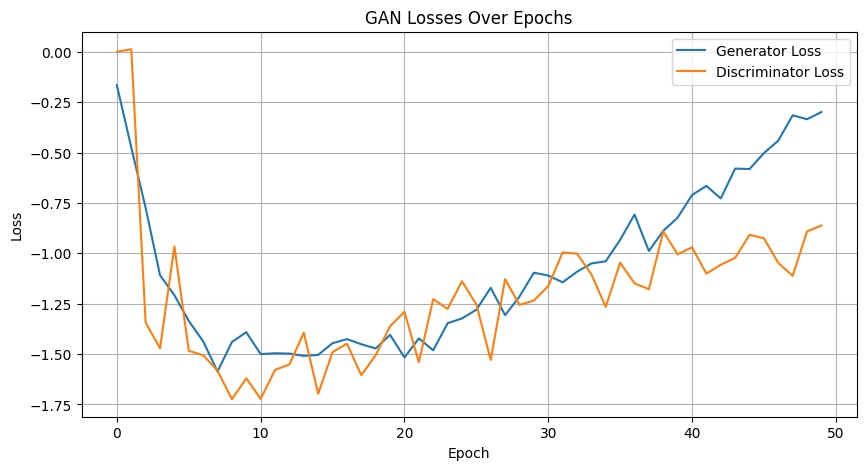

In [64]:
GANEvaluation().plot_losses(model.get_losses())

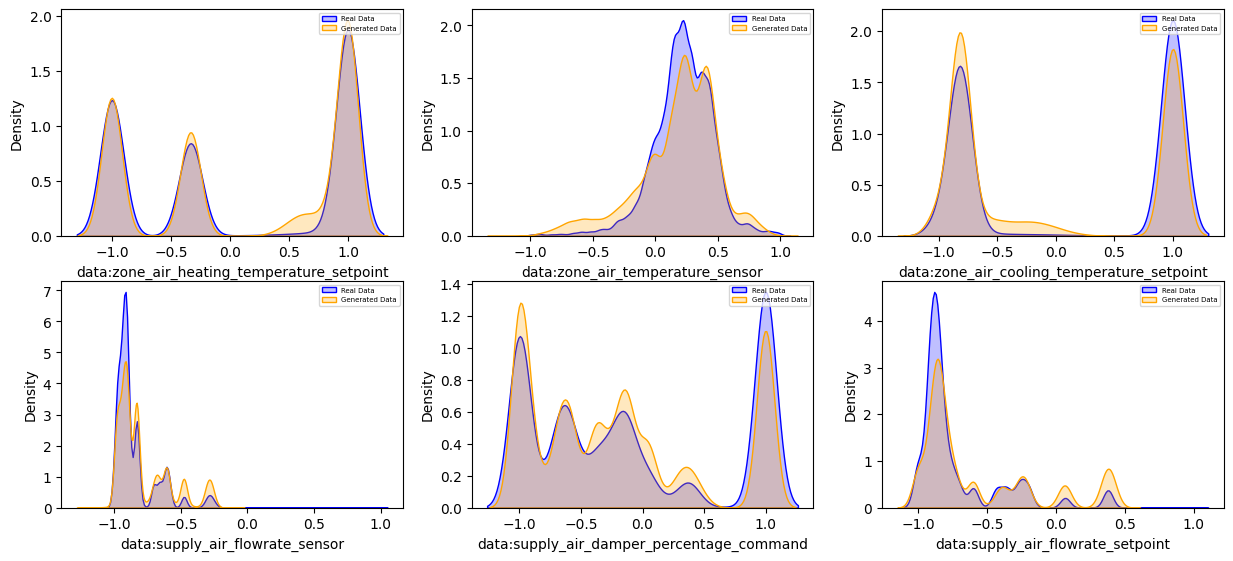

In [57]:
GANEvaluation().plot_kde(data=[scaled_df, synthetic_data])

In [65]:
ana_sample =  ana_df.head(1)   # Get 1 Anomaly sample for test
nor_sample = scaled_df.head(1)     # Get 1 Normal sample for test

# Get the noise vector that generates a sample closes to the original sample. Compare the samples and get anomaly score (MSE)
x = model.generate_sample_close_to(ana_sample, learning_rate=2)
generated_sample = model.single_sample(1, noise=x)
mse = tf.reduce_mean(tf.abs(generated_sample - ana_sample))
print(mse)

# Get the noise vector that generates a sample closes to the original sample. Compare the samples and get anomaly score (MSE)
x = model.generate_sample_close_to(nor_sample, learning_rate=2)
generated_sample = model.single_sample(1, noise=x)
mse = tf.reduce_mean(tf.abs(generated_sample - nor_sample))
print(mse)

tf.Tensor(0.00024636059488371737, shape=(), dtype=float64)
tf.Tensor(0.0016140519323427198, shape=(), dtype=float64)


In [ ]:
# PARAMS
NI=1000     # NUM ITERATION FOR NOISE OPTIMIZATION
LR=2        # LEARNING RATE FOR NOISE OPTIMIZATION
N = 20     # NUMS SAMPLE OF EACH CLASS FOR TEST

In [ ]:
def get_gen_samples_tuple(sample, print_loss=False):
  noise = model.generate_sample_close_to(sample, num_iterations=NI, learning_rate=LR, verbose=False)
  generated_sample = model.single_sample(1, noise=noise)
  if print_loss:
    generated_sample_np = generated_sample.values.flatten()
    ana_sample_np = sample.values.flatten()
    print(np.mean(np.abs(generated_sample_np - ana_sample_np)))

  return (sample, generated_sample)

In [ ]:
# Test on 100 Anomaly Samples
ana_sample_arr = []
arr = []
for i in tqdm(range(N)):
  sample =  ana_df.iloc[i:i+1]
  ana_sample_arr.append(get_gen_samples_tuple(sample, print_loss=True))

  0%|          | 0/500 [00:00<?, ?it/s]

0.00044271138480929856
0.0010286681024729665
0.001860829253534609
0.044457467430814475
0.023923621086619495
0.011162622749267955
0.00431937999271978
0.001524329319275754
0.00064291851345463
0.0006243015851946088
0.0009263447143339579
0.0020634970472950542
0.06475394728381445
0.00098309903485642
0.0008739664340074171
0.0009882166060005647
0.0006934535486667152
0.0004911915250500887
0.0009156099376477397
0.000996164523407922
0.0011614411910373563
0.0009930156250988985
0.0009818852873739643
0.0010348341393583334
0.0008969749871014417
0.0005115364192514968
0.0009685280152068829
0.0007699844877965661
0.00047353906837988013
0.0007689643425419154
0.0011098987326983722
0.0007721872392933473
0.0011423875352754114
1.87707265385829e-05
0.0005985192330880592
2.202900079167902e-05
0.0007801223500294765
2.03614034492335e-05
0.0006377143556478329
3.4004320840936665e-05
0.0005116349248005201
0.0007693179082697149
0.0006636412383682067
0.0008126762262916759
0.0005265761324099635
0.0007736485292602577
0

In [ ]:
import random
random.seed(42)
# Test on 100 Anomaly Samples
nor_sample_arr = []
arr = []
for i in tqdm(range(N)):
  while True:
    try:
      random_id = random.randint(0, len(df) - 5000)
      sample =  scaled_df.iloc[random_id:random_id+1]
      nor_sample_arr.append(get_gen_samples_tuple(sample, print_loss=True))
      break
    except:
      pass

  0%|          | 0/500 [00:00<?, ?it/s]

0.00014516011698937023
2.7123145194596354e-05
4.675173272792344e-05
8.830608043722266e-05
0.000159391017598746
0.0008167085266577769
6.427017257998324e-05
0.0001541012119654813
4.407027013514364e-06
6.907285246757211e-05
1.9739938150972514e-05
1.3323284301728263e-05
6.0701083645873606e-06
7.131962257619455e-05
2.788626022875995e-06
0.00022299406611973419
0.0002295214841153669
9.490033612920741e-05
3.923239409313328e-05
7.1560522212902e-05
3.5509706165800146e-05
0.00015604692595947803
0.0010599589950591088
0.00015533325809678292
0.0002444504459069019
0.001653265062266621
0.00017043992160206226
0.00018731755691507937
5.6071614114486246e-05
0.00017544815504844102
0.0003129245352451367
0.00019239882148024134
0.00015941098980132006
8.270708916417273e-05
0.0008514964511538714
7.191415929175503e-05
0.0010944984455202773
0.0004270080402238215
0.00018641548673060485
0.0009963462832002778
8.892635820603734e-05
5.291987745280682e-06
9.15383849048786e-05
0.00018040009731174386
0.000182431601942788

In [ ]:
def get_losses(sample_array, loss='mae'):
  l_array = []
  for i in sample_array:
    s1 = i[0].values.flatten()
    s2 = i[1].values.flatten()
    if loss == 'mae':
      l_array.append(np.mean(np.abs(s1 - s2)))
    elif loss == 'mse':
      l_array.append(np.mean(np.square(s1 - s2)))
    elif loss == 'rmse':
      l_array.append(np.sqrt(np.mean(np.square(s1 - s2))))
    elif loss == 'cosine':
      l_array.append(1 - np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2)))
  return l_array

In [ ]:
measured_loss = 'rmse'

ana_sample_arr_x = get_losses(ana_sample_arr, loss=measured_loss)
nor_sample_arr_x = get_losses(nor_sample_arr, loss=measured_loss)

In [ ]:
real_labels = ([0] * len(ana_sample_arr)) + ([1] * len(nor_sample_arr))

for i in range(10, 100):
  thresh = i / 100000
  ana_sample_arr_class = [0 if x > thresh else 1 for x in ana_sample_arr_x]
  nor_sample_arr_class = [0 if x > thresh else 1 for x in nor_sample_arr_x]
  print(thresh, sklearn.metrics.accuracy_score(real_labels, ana_sample_arr_class+nor_sample_arr_class))

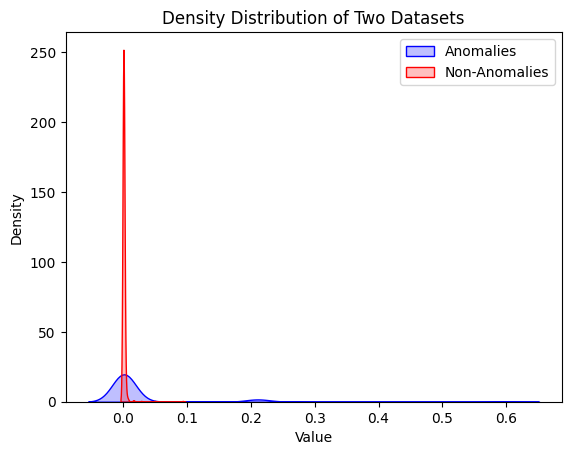

In [ ]:
import seaborn as sns


# Plot the distributions of the anomaly scores for Anomalies and Non-Anomalies
sns.kdeplot(ana_sample_arr_x, shade=True, color="blue", label="Anomalies")  # 'label' will be used for the legend
sns.kdeplot(nor_sample_arr_x, shade=True, color="red", label="Non-Anomalies")

plt.title("Density Distribution of Two Datasets")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()